# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


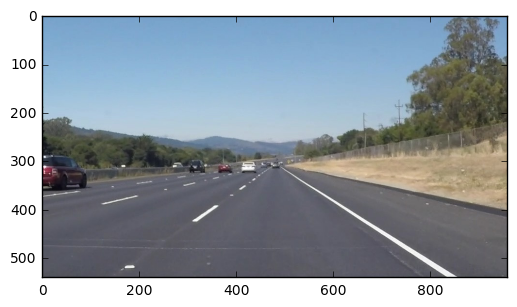

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [1]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

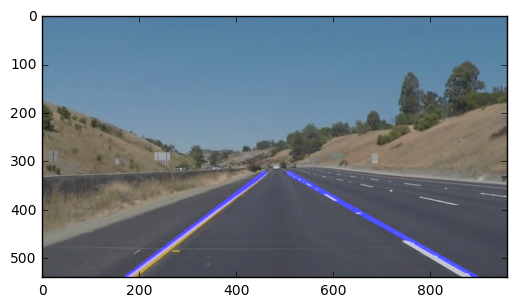

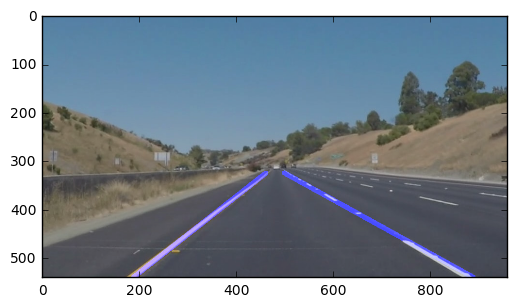

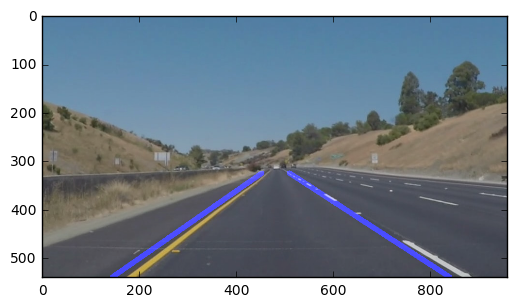

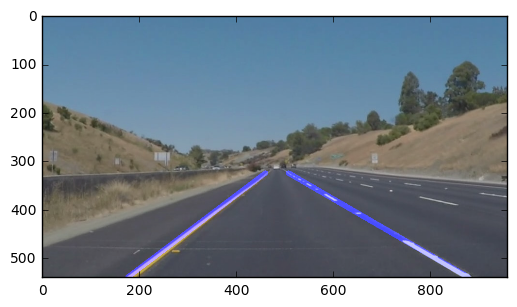

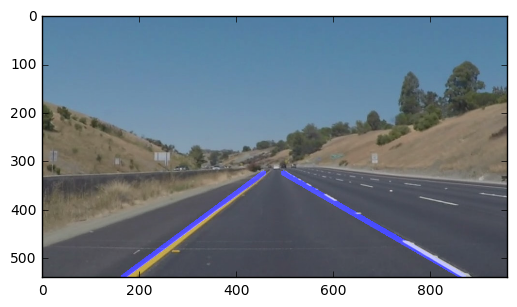

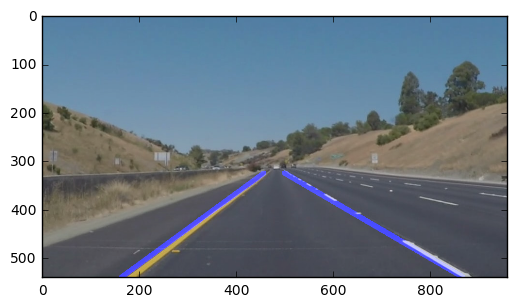

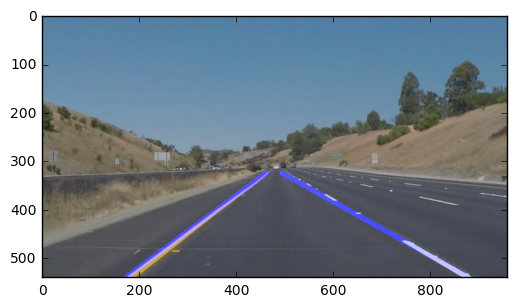

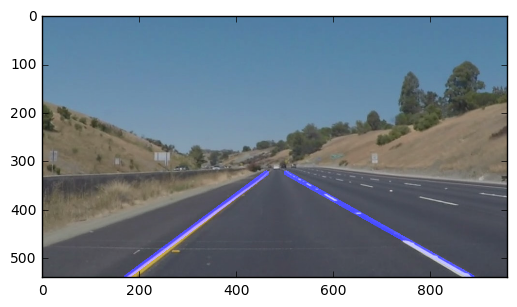

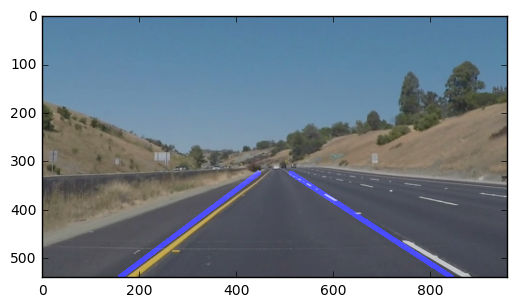

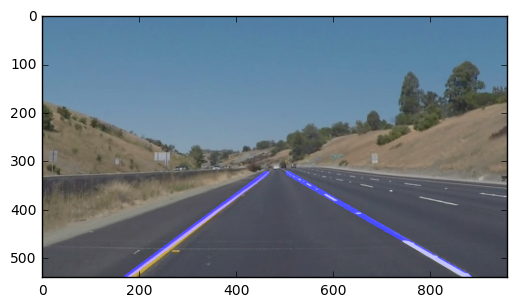

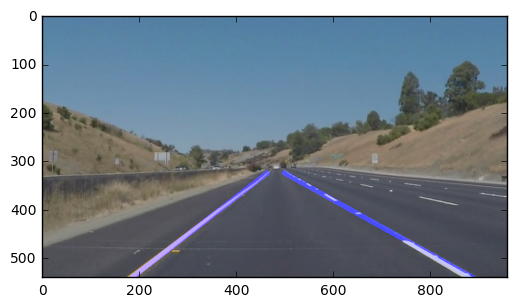

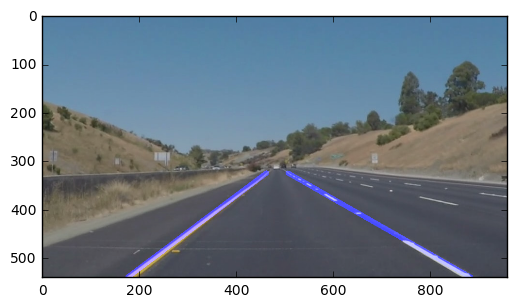

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import operator
import os

%matplotlib inline
folder = "test_images/"
images = os.listdir(folder)
#reading in an image
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')


#Converts to Grayscale. returns a grayscale image
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#define the mask for the image. Returns a masked image
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

##perform the Gaussian conversion. Returns an image
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

##performs canny edge detection. Returns an image
def cannyEdges(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

##Uses Hough space to determine lines and draw them on the image.  Returns an image with 1 right and 1 left line
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #draw_linesTest(line_img, lines[5])
    prepare_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

#takes Hough lines and splits them into left and right lines.
#It then takes the lines, performs some averages and uses one left and one right line
#returns an image with 1 left and 1 right line
def prepare_lines(img, lines):
    linesAndSlope = determine_slope(lines) 
    
    leftLines = []
    rightLines = []
    #now we have an array with coordinates and slope
    for i in linesAndSlope:
        try:            
            if i[4]>0:
                rightLines.append(i)
            else:
                leftLines.append(i)
        except IndexError:
            continue
    
    rightLines = determine_lines_within_average_slope(rightLines)  
    leftLines = determine_lines_within_average_slope(leftLines)    
    #now we have 2 arrays we need to average them to extrapolate the line    
      
    draw_lines(img, rightLines, leftLines)

#Draws the actual lines on the image
#returns an image
def draw_lines(img, leftlines, rightLines):
    newMaskColor = [0, 0, 255]  
    thickness=10 
    imshape = img.shape   
    averageX = (np.average(leftlines, axis=0)[0]+np.average(leftlines, axis=0)[2])/2
    averageY = (np.average(leftlines, axis=0)[1]+np.average(leftlines, axis=0)[3])/2 
    averageSlope = np.average(leftlines, axis=0)[4]
    newLineLeft = extrapolate_lines(averageX, averageY, averageSlope, imshape[0], topOfMask + 25)
    cv2.line(img, (int(newLineLeft[0]), int(newLineLeft[1])), (int(newLineLeft[2]), int(newLineLeft[3])), newMaskColor, thickness)
    
    averageX = (np.average(rightLines, axis=0)[0]+np.average(rightLines, axis=0)[2])/2
    averageY = (np.average(rightLines, axis=0)[1]+np.average(rightLines, axis=0)[3])/2 
    averageSlope = np.average(rightLines, axis=0)[4]
    newLineRight = extrapolate_lines(averageX, averageY, averageSlope, imshape[0], topOfMask + 25)
    cv2.line(img, (int(newLineRight[0]), int(newLineRight[1])), (int(newLineRight[2]), int(newLineRight[3])), newMaskColor, thickness)
    
   
#lines from the hough transformation do not have the slope attached to them
#returns an array of lines with slopes.
def determine_slope(lines):
    #get the slope for each line
    allLines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            slopeLine = [x1,y1,x2,y2,slope]
            allLines.append(slopeLine)
    return allLines  

#Finds the average slope of all the left or right lines
# it then removes any which are above or below the threshold
def determine_lines_within_average_slope(lines):
    averageSlope = np.mean(lines, axis = 0)[4]
    lowThreshold = averageSlope - .1
    highThreshold = averageSlope + .1
    returnLines = []
    #print("low", lowThreshold)
    #print("high", highThreshold)
    for i in lines:        
        if i[4]>lowThreshold and i[4] < highThreshold:
            #TODO: test this later, maybe widen the mask or something
            returnLines.append(i)
    return returnLines
    

#takes a incomplete line and extrapolates it to the bottom of the image and the top of the image mask.
#returns a line
def extrapolate_lines(x, y, slope, bottomY, topY): 
    yIntercept = y - (slope * x)
    #yIntercept = topY - (averageSlope*int(averageStartPosition[0][0]))
    #print("y intercept", yIntercept)
    topX = (topY - yIntercept)/slope
    bottomX = (bottomY - yIntercept)/slope 
    #print("topX ", topX)
    #print("topY ", topY)
    #print("BottomX", bottomX)
    #print("BottomY", bottomY)
    newLine = [int(topX), int(topY), int(bottomX), int(bottomY)]
    #print("line out = ", newLine)
    
    return newLine

def read_and_mark_image(image):

    #1. Convert to grayscale
    
    
    image =  (grayscale(image))
    #2: gaussian conversion -- skipping this as canny does a 5x5 already.

    
    #3: perform canny edge detection
    canny = cannyEdges(image, lowThreshold, highThreshold)
    imshape = canny.shape
    
    #4: apply the image mask    
    vertices = np.array([[(115,imshape[0]),(470, topOfMask), (500,topOfMask), (900,imshape[0])]], dtype=np.int32)
    maskedImage = region_of_interest(canny, vertices)
    
    #5 Perform the Hough Transfor,    
    houghImage = hough_lines(maskedImage,rho, theta, threshold, min_line_length, max_line_gap )
    finalImage =  weighted_img(houghImage, originalImage)
    return finalImage

originalImage = image
lowThreshold = 50
highThreshold = 360
topOfMask = 300
rho =5
theta = np.pi/180
threshold = 200
min_line_length = 10
max_line_gap = 1   

for imageFile in images:            
    image = mpimg.imread(folder + imageFile)
    displayImage = read_and_mark_image(image)
    plt.figure()
    plt.imshow(displayImage, cmap='Greys_r')
    filename, ext = os.path.splitext(imageFile)
    new_filename = os.path.join(folder, filename + "_out" + ext)
    mpimg.imsave(new_filename, displayImage, cmap='Greys_r')


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ImportError: No module named 'moviepy'

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))